## Amazon Bedrock LLM Router Evaluation

### Intro and Goal
This Jupyter Notebook is designed to test an LLM (Large Language Model) routing system on a Text-to-SQL use case.

The goal is to take a prompt, determine the level of complexity and then route the prompt either to a small or large LLM to generate the corresponding SQL query.

The notebook is structured as follows:
1. Create a ground truth dataset comprised of questions and SQL queries for a given database (e.g. Northwind)
2. Finetune LLM Classifier to predict level of complexity based on provided user prompt and database schema.
3. Evaluate accuracy, cost, and latency of LLM classifier router approach compared to large LLM.

In [ ]:
# 1. Create a conda environment

# !conda create -y --name bedrock-router-eval python=3.11.8
# !conda init && activate bedrock-router-eval
# !conda install -n bedrock-router-eval ipykernel --update-deps --force-reinstall -y
# !conda install -c conda-forge ipython-sql

In [3]:
# 2. Install dependencies

# !pip install -r requirements.txt

  Using cached filelock-3.15.4-py3-none-any.whl.metadata (2.9 kB)
  Using cached pyarrow_hotfix-0.6-py3-none-any.whl.metadata (3.6 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached pandas-2.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached xxhash-3.4.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached multiprocess-0.70.16-py311-none-any.whl.metadata (7.2 kB)
  Using cached aiosignal-1.3.1-py3-none-any.whl.metadata (4.0 kB)
  Using cached frozenlist-1.4.1-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached multidict-6.0.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.2 kB)
  Using cached yarl-1.9.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (31 kB)
  Using cached charset_normalizer-3

In [1]:
# 3. Import necessary libraries and load environment variables
import numpy as np
from scipy.spatial.distance import cdist
import json
from dotenv import load_dotenv, find_dotenv
import os
import boto3
import sqlite3
from pandas.io import sql
from botocore.config import Config

# loading environment variables that are stored in local file
local_env_filename = 'bedrock-router-eval.env'
load_dotenv(find_dotenv(local_env_filename),override=True)

os.environ['REGION'] = os.getenv('REGION')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN')
REGION = os.environ['REGION']
HF_TOKEN = os.environ['HF_TOKEN']

# Initialize Bedrock runtime
config = Config(
   retries = {
      'max_attempts': 10,
      'mode': 'standard'
   }
)
bedrock_runtime_client = boto3.client(
        service_name="bedrock-runtime",
        config=config,
        region_name=REGION)

bedrock_client = boto3.client(service_name='bedrock', region_name=REGION)
athena_client = boto3.client('athena')
glue_client = boto3.client('glue')
s3_client = boto3.client('s3')

MODEL_ID = "anthropic.claude-3-haiku-20240307-v1:0" # "anthropic.claude-3-5-sonnet-20240620-v1:0" "meta.llama3-1-70b-instruct-v1:0"

SQL_DATABASE = 'LOCAL' #GLUE
SQL_DIALECT = 'SQlite' #awsathena

if SQL_DATABASE == 'LOCAL':
   %load_ext sql
   %sql sqlite:///routedb.db

In [32]:
# 4. Define Helper functions
# TO DO: decide if we remove Bedrock Batch due to filesize restrictions

import boto3
import pandas as pd
import io
import json
from io import StringIO
import sqlparse
import sqlite3
import time
import matplotlib.pyplot as plt
import re
import typing as t
import time
from queue import Queue
from threading import Thread


SCORE_PATTERN = r'<score>(.*?)</score>'
REASONING_PATTERN = r'<thinking>(.*?)</thinking>'
SQL_PATTERN = r'<SQL>(.*?)</SQL>'

# Strip out the portion of the response with regex.
def extract_with_regex(response, regex):
    matches = re.search(regex, response, re.DOTALL)
    # Extract the matched content, if any
    return matches.group(1).strip() if matches else None

def format_results(grade: str, chat_conversation: list[dict]) -> dict:
    reasoning: str = extract_with_regex(grade, REASONING_PATTERN)
    sqlquery: str =  extract_with_regex(grade, SQL_PATTERN)
    score: str =  extract_with_regex(grade, SCORE_PATTERN)

    return {
        'chat_conversation': chat_conversation,
        'reasoning': reasoning,
        'score': score
    }

def balance_dataset(
    dataset_df: pd.DataFrame, key: str, random_state: int = 42
) -> pd.DataFrame:
    """
    Balance the dataset by oversampling the minority class.
    """
    # Determine the minority class
    min_count = dataset_df[key].value_counts().min()

    # Create a balanced DataFrame
    sampled_dfs = []
    for label in dataset_df[key].unique():
        sampled = dataset_df[dataset_df[key] == label].sample(
            n=min_count, random_state=random_state
        )
        sampled_dfs.append(sampled)

    balanced_df = pd.concat(sampled_dfs).sample(frac=1, random_state=random_state)
    return balanced_df
    
def visualize_distribution(df, key):
    # Check if 'score' column exists in the DataFrame
    if key not in df.columns:
        raise ValueError(f"The DataFrame does not contain a '{key}' column.")
    
    # Count the frequency of each score
    score_counts = df[key].value_counts().sort_index()
    
    # Create a bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(score_counts.index, score_counts.values)
    
    # Customize the chart
    plt.title(f'Distribution of {key}')
    plt.xlabel(f'{key}')
    plt.ylabel('Frequency')
    plt.xticks(range(int(score_counts.index.min()), int(score_counts.index.max()) + 1))
    
    # Add value labels on top of each bar
    for i, v in enumerate(score_counts.values):
        plt.text(score_counts.index[i], v, str(v), ha='center', va='bottom')
    
    # Display the chart
    plt.tight_layout()
    plt.show()

def execution_accuracy(generated_sql, labeled_sql):
    """
    Calculate Execution Accuracy (EX)
    
    Args:
    generated_sql (str): The SQL query generated by the model
    labeled_sql (str): The labeled (ground truth) SQL query
    
    Returns:
    float: 1.0 if the queries match, 0.0 otherwise
    """
    # Normalize and compare the SQL queries
    gen_normalized = sqlparse.format(generated_sql, strip_comments=True, reindent=True)
    lab_normalized = sqlparse.format(labeled_sql, strip_comments=True, reindent=True)
    
    return 1.0 if gen_normalized == lab_normalized else 0.0

def exact_set_match_accuracy(generated_sql, labeled_sql, db_connection):
    """
    Calculate Exact Set Match Accuracy (EM)
    
    Args:
    generated_sql (str): The SQL query generated by the model
    labeled_sql (str): The labeled (ground truth) SQL query
    db_connection: A database connection object
    
    Returns:
    float: 1.0 if the result sets match, 0.0 otherwise
    """
    try:
        # Execute both queries
        gen_result = pd.read_sql_query(generated_sql, db_connection)
        lab_result = pd.read_sql_query(labeled_sql, db_connection)
        
        # Compare the result sets
        return 1.0 if gen_result.equals(lab_result) else 0.0
    except Exception as e:
        print(f"Error executing SQL: {e}")
        return 0.0

def valid_efficiency_score(generated_sql, labeled_sql, db_connection):
    """
    Calculate Valid Efficiency Score (VES)
    
    Args:
    generated_sql (str): The SQL query generated by the model
    labeled_sql (str): The labeled (ground truth) SQL query
    db_connection: A database connection object
    
    Returns:
    float: The VES score
    """
    try:
        # Execute both queries and measure execution time
        gen_start = time.time()
        gen_result = pd.read_sql_query(generated_sql, db_connection)
        gen_time = time.time() - gen_start
        # print(f'generated_sql_execution_time: {gen_time}')
        lab_start = time.time()
        lab_result = pd.read_sql_query(labeled_sql, db_connection)
        lab_time = time.time() - lab_start
        # print(f'labeled_sql_execution_time: {lab_time}')
        
        # Check if results match
        if not gen_result.equals(lab_result):
            return 0.0
        
        # Calculate VES
        ves = min(lab_time / gen_time, 1.0)
        return ves
    except Exception as e:
        print(f"Error executing SQL: {e}")
        return 0.0


def dataframe_to_s3_jsonl(df, bucket_name, prefix, filename):
    """
    Convert a pandas DataFrame to JSONL format and upload it to S3.

    Parameters:
    df (pandas.DataFrame): The DataFrame to be converted and uploaded.
    bucket_name (str): The name of the S3 bucket.
    prefix (str): The S3 prefix (folder path) where the file will be uploaded.
    filename (str): The name of the file to be created in S3.

    Returns:
    str: The S3 URI of the uploaded file.
    """
    # Convert DataFrame to JSONL
    jsonl_buffer = StringIO()
    for _, row in df.iterrows():
        json.dump(row.to_dict(), jsonl_buffer)
        jsonl_buffer.write('\n')
    jsonl_buffer.seek(0)

    # Upload the JSONL data to S3
    s3_key = f"{prefix.rstrip('/')}/{filename}"
    s3_client.put_object(
        Bucket=bucket_name,
        Key=s3_key,
        Body=jsonl_buffer.getvalue(),
        ContentType='application/json'
    )

    # Return the S3 URI of the uploaded file
    return f"s3://{bucket_name}/{s3_key}"


def download_and_parse_jsonl(bucket_name, object_key):
    """
    Downloads a JSONL file from an Amazon S3 bucket and parses it into a pandas DataFrame.

    Args:
        bucket_name (str): The name of the S3 bucket where the JSONL file is stored.
        object_key (str): The key (path) of the JSONL file in the S3 bucket.

    Returns:
        pandas.DataFrame: A DataFrame containing the data from the JSONL file.
    """
    

    # Download the JSONL file from S3
    response = s3_client.get_object(Bucket=bucket_name, Key=object_key)
    jsonl_data = response['Body'].read().decode('utf-8')

    # Parse the JSONL data into a list of dictionaries
    data = [json.loads(line) for line in jsonl_data.strip().split('\n')]

    # Create a DataFrame from the list of dictionaries
    df = pd.DataFrame(data)

    return df

def check_job_status_and_wait(job_arn):
    # # check status
    # bedrock.get_model_invocation_job(jobIdentifier=jobArn)['status']

    # # list batch jobs
    # bedrock.list_model_invocation_jobs(
    #     maxResults=10,
    #     statusEquals="Failed",
    #     sortOrder="Descending"
    # )

    while True:
        job_status = bedrock_client.get_model_invocation_job(jobIdentifier=job_arn)['status']
        print(f"Job status: {job_status}")

        if job_status == 'COMPLETED':
            output_s3_uri = bedrock_client.get_model_invocation_job(jobIdentifier=job_arn)['outputDataConfig']['s3OutputDataConfig']['s3Uri']
            output_file_key = output_s3_uri.replace(f"s3://{output_bucket}/{output_prefix}", "")
            output_file_name = output_file_key.split("/")[-1]
            break
        elif job_status == 'FAILED':
            print("Job failed.")
            break
        else:
            time.sleep(60)  # Wait for 1 minute before checking again
    
    return output_s3_uri

def get_schema(database_name, table_names=None):
    try:
        
        table_schema_list = []
        response = glue_client.get_tables(DatabaseName=database_name)

        all_table_names = [table['Name'] for table in response['TableList']]

        if table_names:
            table_names = [name for name in table_names if name in all_table_names]
        else:
            table_names = all_table_names

        for table_name in table_names:
            response = glue_client.get_table(DatabaseName=database_name, Name=table_name)
            columns = response['Table']['StorageDescriptor']['Columns']
            schema = {column['Name']: column['Type'] for column in columns}
            table_schema_list.append({"Table: {}".format(table_name): 'Schema: {}'.format(schema)})
    except Exception as e:
        print(f"Error: {str(e)}")
    return table_schema_list

def execute_athena_query(database, query):
    # Start query execution
    response = athena_client.start_query_execution(
        QueryString=query,
        QueryExecutionContext={
            'Database': database
        },
        ResultConfiguration={
            'OutputLocation': outputLocation
        }
    )

    # Get query execution ID
    query_execution_id = response['QueryExecutionId']
    print(f"Query Execution ID: {query_execution_id}")

    # Wait for the query to complete
    response_wait = athena_client.get_query_execution(QueryExecutionId=query_execution_id)

    while response_wait['QueryExecution']['Status']['State'] in ['QUEUED', 'RUNNING']:
        print("Query is still running...")
        response_wait = athena_client.get_query_execution(QueryExecutionId=query_execution_id)

    print(f'response_wait {response_wait}')

    # Check if the query completed successfully
    if response_wait['QueryExecution']['Status']['State'] == 'SUCCEEDED':
        print("Query succeeded!")

        # Get query results
        query_results = athena_client.get_query_results(QueryExecutionId=query_execution_id)

        # Extract and return the result data
        code = 'SUCCEEDED'
        return code, extract_result_data(query_results)

    else:
        print("Query failed!")
        code = response_wait['QueryExecution']['Status']['State']
        message = response_wait['QueryExecution']['Status']['StateChangeReason']
    
        return code, message

def extract_result_data(query_results):
    #Return a cleaned response to the agent
    result_data = []

    # Extract column names
    column_info = query_results['ResultSet']['ResultSetMetadata']['ColumnInfo']
    column_names = [column['Name'] for column in column_info]

    # Extract data rows
    for row in query_results['ResultSet']['Rows']:
        data = [item['VarCharValue'] for item in row['Data']]
        result_data.append(dict(zip(column_names, data)))

    return result_data

# sql_dialect = awsathena or SQLite
def build_sqlquerygen_prompt(user_question: str, sql_database_schema: str):
    prompt = """You will be provided with the original user question and a SQL database schema. 
                Only return the SQL query and nothing else.
                Here is the original user question.
                <user_question>
                {user_question}
                </user_question>

                Here is the SQL database schema.
                <sql_database_schema>
                {sql_database_schema}
                </sql_database_schema>
                
                Instructions:
                Generate a SQL query that answers the original user question.
                Use the schema, first create a syntactically correct {sql_dialect} query to answer the question. 
                Never query for all the columns from a specific table, only ask for a few relevant columns given the question.
                Pay attention to use only the column names that you can see in the schema description. 
                Be careful to not query for columns that do not exist. 
                Pay attention to which column is in which table. 
                Also, qualify column names with the table name when needed.
                If you cannot answer the user question with the help of the provided SQL database schema, 
                then output that this question question cannot be answered based of the information stored in the database.
                You are required to use the following format, each taking one line:
                Return the sql query inside the <SQL></SQL> tab.
                """.format(
                    user_question=user_question,
                    sql_database_schema=sql_database_schema,
                    sql_dialect=SQL_DIALECT
                ) 
    return prompt


def build_prediction_prompt(user_question: str, sql_database_schema: str):
    prompt = """You will be provided with the original user question and a SQL database schema. 
                
                Here is the original user question.
                <user_question>
                {user_question}
                </user_question>

                Here is the SQL database schema for the SQL dialect {sql_dialect}.
                <sql_database_schema>
                {sql_database_schema}
                </sql_database_schema>
                
                Instructions:
                Your prediction should infer the level of proficiency needed to create a SQL query effectively. 
                Use a scale from 1 to 5, where a higher score indicates a higher anticipated quality of response. 
                
                Here is the rubric:
                - High Rating (4-5): The AI assistant can produce a very efficient SQL query, showing deep understanding, detailed insight of the SQL database schema, and high relevance.
                - Medium Rating (3): The AI assistant can provide an adequate SQL query with moderate detail, relevance, and factual accuracy.
                - Low Rating (1-2): The AI assistant will struggle to produce a valid SQL query due to the question's difficulty, vagueness, and or the complexity of the SQL database schema and the assistant's limitations.
                
                Provide your prediction inside <score></score> tags.
                """.format(
                    user_question=user_question,
                    sql_database_schema=sql_database_schema,
                    sql_dialect=SQL_DIALECT
                ) 
    return prompt


def build_grader_prompt(original_instruction: str, sql_query: str, sql_query_run_result: str, sql_query_run_error: str, groundtruth_sql_query: str,ex_score:str, em_score: str, ves_score: str):
    prompt = """You will be provided with the original user prompt, context, generated SQL query and SQL result, which is trying to answer the initial user prompt.
                You also get the groundtruth SQL query, SQL evaluation metrics, and a rubric that instructs you on how to grade the generated SQL query.

                Here are the original instructions for the SQL query.
                <original_instruction>
                {original_instruction}
                </original_instruction>

                Here is the generated SQL query based on these instructions.
                <sql_query>
                {sql_query}
                </sql_query>

                Here is the SQL result based on the generated SQL query.
                <sql_query_run_result>
                {sql_query_run_result}
                </sql_query_run_result>

                Any SQL errors that might have occured based on the generated SQL query.
                <sql_query_run_error>
                {sql_query_run_error}
                </sql_query_run_error>

                Here is the groundtruth SQL query for comparison with the generated SQL query.
                <groundtruth_sql_query>
                {groundtruth_sql_query}
                </groundtruth_sql_query>
                
                And here are the corresponding Text-to-SQL metrics:
                - Execution Accuracy, which compares the generated SQL query to the labeled SQL query to determine if its a match or not: {ex_score} ;
                - Exact Set Match Accuracy (EM), which evaluates if the returned result set actually answer the question, regardless of how the query was written: {em_score} ;
                - Valid Efficiency Score (VES), which compares the runtime of the SQL provided as groundtruth to the generated SQL query: {ves_score} ; 

                Here is the rubric on how to grade the generated SQL query:
                - High Rating (4-5): Reserved for SQL queries that are very close to the quality of the groundtruth_sql_query (reference) or even better and are performant.
                - Medium Rating (3): Reserved for SQL queries that have moderate quality compared to the groundtruth_sql_query (reference).
                - Low Rating (1-2): Allocated to SQL queries that are much lower quality compared to the groundtruth_sql_query (reference) or completely wrong and produced an error.
                
                First, think through the SQL query rating based on the rubric inside <thinking></thinking> tags.
                Use a scale from 1 to 5, where a higher score indicates a higher quality of the SQL query, provide the score inside <score></score> tags.
                
                """.format(
                    sql_query= sql_query,
                    sql_query_run_error= sql_query_run_error,
                    original_instruction= original_instruction,
                    sql_query_run_result= sql_query_run_result,
                    groundtruth_sql_query= groundtruth_sql_query,
                    ex_score=ex_score,
                    em_score=em_score,
                    ves_score=ves_score,
                ) 
    return prompt



class Util():
    def __init__(self,
        debug: bool = False

    ):

        self.debug = debug

    def calculate_cost(self, usage, model_id):
        '''
        Takes the usage tokens returned by Bedrock in input and output, and coverts to cost in dollars.
        '''
        
        input_token_haiku = 0.25/1000000
        output_token_haiku = 1.25/1000000
        input_token_sonnet = 3.00/1000000
        output_token_sonnet = 15.00/1000000
        input_token_opus = 15.00/1000000
        output_token_opus = 75.00/1000000
        
        input_token_titan_embeddingv1 = 0.1/1000000
        input_token_titan_embeddingv2 = 0.02/1000000
        input_token_titan_embeddingmultimodal = 0.8/1000000
        input_token_titan_premier = 0.5/1000000
        output_token_titan_premier = 1.5/1000000
        input_token_titan_lite = 0.15/1000000
        output_token_titan_lite = 0.2/1000000
        input_token_titan_express = 0.2/1000000
        output_token_titan_express = 0.6/1000000
       
        input_token_cohere_command = 0.15/1000000
        output_token_cohere_command = 2/1000000
        input_token_cohere_commandlight = 0.3/1000000
        output_token_cohere_commandlight = 0.6/1000000
        input_token_cohere_commandrplus = 3/1000000
        output_token_cohere_commandrplus = 15/1000000
        input_token_cohere_commandr = 5/1000000
        output_token_cohere_commandr = 1.5/1000000
        input_token_cohere_embedenglish = 0.1/1000000
        input_token_cohere_embedmultilang = 0.1/1000000

        input_token_llama3_8b = 0.4/1000000
        output_token_llama3_8b = 0.6/1000000
        input_token_llama3_70b = 2.6/1000000
        output_token_llama3_70b = 3.5/1000000

        input_token_mistral_8b = 0.15/1000000
        output_token_mistral_8b = 0.2/1000000
        input_token_mistral_large = 4/1000000
        output_token_mistral_large = 12/1000000

        cost = 0

        if 'haiku' in model_id:
            cost+= usage['inputTokens']*input_token_haiku
            cost+= usage['outputTokens']*output_token_haiku
        if 'sonnet' in model_id:
            cost+= usage['inputTokens']*input_token_sonnet
            cost+= usage['outputTokens']*output_token_sonnet
        if 'opus' in model_id:
            cost+= usage['inputTokens']*input_token_opus
            cost+= usage['outputTokens']*output_token_opus
        if 'amazon.titan-embed-text-v1' in model_id:
            cost+= usage['inputTokens']*input_token_titan_embeddingv1
        if 'amazon.titan-embed-text-v2' in model_id:
            cost+= usage['inputTokens']*input_token_titan_embeddingv2
        if 'cohere.embed-multilingual' in model_id:
            cost+= usage['inputTokens']*input_token_cohere_embedmultilang
        if 'cohere.embed-english' in model_id:
            cost+= usage['inputTokens']*input_token_cohere_embedenglish 
        if 'meta.llama3-8b-instruct' in model_id:
            cost+= usage['inputTokens']*input_token_llama3_8b
            cost+= usage['outputTokens']*output_token_llama3_8b
        if 'meta.llama3-70b-instruct' in model_id:
            cost+= usage['inputTokens']*input_token_llama3_70b
            cost+= usage['outputTokens']*output_token_llama3_70b
        if 'cohere.command-text' in model_id:
            cost+= usage['inputTokens']*input_token_cohere_command
            cost+= usage['outputTokens']*output_token_cohere_command
        if 'cohere.command-light-text' in model_id:
            cost+= usage['inputTokens']*input_token_cohere_commandlight
            cost+= usage['outputTokens']*output_token_cohere_commandlight
        if 'cohere.command-r-plus' in model_id:
            cost+= usage['inputTokens']*input_token_cohere_commandrplus
            cost+= usage['outputTokens']*output_token_cohere_commandrplus
        if 'cohere.command-r' in model_id:
            cost+= usage['inputTokens']*input_token_cohere_commandr
            cost+= usage['outputTokens']*output_token_cohere_commandr
        if 'amazon.titan-text-express' in model_id:
            cost+= usage['inputTokens']*input_token_titan_express
            cost+= usage['outputTokens']*output_token_titan_express
        if 'amazon.titan-text-lite' in model_id:
            cost+= usage['inputTokens']*input_token_titan_lite
            cost+= usage['outputTokens']*output_token_titan_lite
        if 'amazon.titan-text-premier' in model_id:
            cost+= usage['inputTokens']*input_token_titan_premier
            cost+= usage['outputTokens']*output_token_titan_premier
        if 'mistral.mixtral-8x7b-instruct-v0:1' in model_id:
            cost+= usage['inputTokens']*input_token_mistral_8b
            cost+= usage['outputTokens']*output_token_mistral_8b

        return cost

class BedrockLLMWrapper():
    def __init__(self,
        model_id: str = 'anthropic.claude-3-haiku-20240307-v1:0', #'anthropic.claude-3-sonnet-20240229-v1:0',
        top_k: int = 5,
        top_p: int = 0.7,
        temperature: float = 0.0,
        max_token_count: int = 4000,
        max_attempts: int = 3,
        debug: bool = False

    ):

        self.model_id = model_id
        self.top_k = top_k
        self.top_p = top_p
        self.temperature = temperature
        self.max_token_count = max_token_count
        self.max_attempts = max_attempts
        self.debug = debug
        self.bedrock_runtime = boto3.client(service_name="bedrock-runtime", config=config, region_name=REGION)
        
    def generate(self,prompt):
        if self.debug: 
            print('entered BedrockLLMWrapper generate')
        attempt = 1

        message = {
            "role": "user",
            "content": [{"text": prompt}]
        }
        messages = []
        messages.append(message)
        
        # model specific inference parameters to use.
        if "anthropic" in self.model_id.lower():
            # system_prompts = [{"text": "You are a helpful AI Assistant."}]
            system_prompts = []
            # Base inference parameters to use.
            inference_config = {
                                "temperature": self.temperature, 
                                "maxTokens": self.max_token_count,
                                "stopSequences": ["\n\nHuman:"],
                                "topP": self.top_p,
                            }
            additional_model_fields = {"top_k": self.top_k}
        else:
            system_prompts = []
            # Base inference parameters to use.
            inference_config = {
                                "temperature": self.temperature, 
                                "maxTokens": self.max_token_count,
                            }
            additional_model_fields = {"top_k": self.top_k}

        if self.debug: 
            print("Sending:\nSystem:\n",system,"\nMessages:\n",str(messages))

        while True:
            try:

                # Send the message.
                response = self.bedrock_runtime.converse(
                    modelId=self.model_id,
                    messages=messages,
                    system=system_prompts,
                    inferenceConfig=inference_config,
                    additionalModelRequestFields=additional_model_fields
                )

                # Log token usage.
                text = response['output'].get('message').get('content')[0].get('text')
                usage = response['usage']
                latency = response['metrics'].get('latencyMs')

                if self.debug: 
                    print(f'text: {text} ; and token usage: {usage} ; and query_time: {latency}')    
                
                break
               
            except Exception as e:
                print("Error with calling Bedrock: "+str(e))
                attempt+=1
                if attempt>self.max_attempts:
                    print("Max attempts reached!")
                    result_text = str(e)
                    break
                else:#retry in 10 seconds
                    print("retry")
                    time.sleep(10)

        # return result_text
        return [text,usage,latency]

    # Threaded function for queue processing.
    def thread_request(self, q, result):
        while not q.empty():
            work = q.get()    #fetch new work from the Queue
            try:
                data = self.generate(work[1])
                result[work[0]] = data  #Store data back at correct index
            except Exception as e:
                print('Error with prompt!',str(e))
                result[work[0]] = (str(e))
            #signal to the queue that task has been processed
            q.task_done()
        return True

    def generate_threaded(self,prompts):
        '''
        Call multi-threaded.
        Returns a dict of the prompts and responses.
        '''
        system=""
        ignore_cache=False
        q = Queue(maxsize=0)
        num_theads = min(50, len(prompts))
        #Populating Queue with tasks
        results = [{} for x in prompts];
        #load up the queue with the promts to fetch and the index for each job (as a tuple):
        for i in range(len(prompts)):
            #need the index and the url in each queue item.
            q.put((i,prompts[i]))
            
        #Starting worker threads on queue processing
        for i in range(num_theads):
            if self.debug:
                print('Starting thread ', i)
            worker = Thread(target=self.thread_request, args=(q,results))
            worker.daemon = True
            worker.start()

        #now we wait until the queue has been processed
        q.join()
        return results
    

def runBedrockBatchJob(modelid,df):
    BEDROCK_BATCH_API = False
    if BEDROCK_BATCH_API == True:
        ## WIP
        # upload df_results dataframe as jsonl to S3
        prefix = 'routeeval/input'
        filename = 'small_llm.jsonl'
        bucket_name = 'felixh-demo'

        s3_uri = dataframe_to_s3_jsonl(df, bucket_name, prefix, filename)
        print(f"File uploaded to: {s3_uri}")

        # generate SQL queries with Bedrock Batch API if filesize is >25mb otherwise use helper class for threaded calls

        input_bucket = bucket_name
        input_prefix = "input/"
        output_bucket = bucket_name
        output_prefix = "output/mistral8binstruct"
        BATCH_ROLE_ARN = 'arn:aws:iam::026459568683:role/admin'

        inputDataConfig=({
            "s3InputDataConfig": {
                "s3Uri": f"s3://{input_bucket}/{input_prefix}"
            }
        })

        outputDataConfig=({
            "s3OutputDataConfig": {
                "s3Uri": f"s3://{output_bucket}/{output_prefix}"
            }
        })

        batch_response=bedrock_client.create_model_invocation_job(
            roleArn=BATCH_ROLE_ARN,
            modelId=modelid,
            jobName="small-llm-genSQL-job",
            inputDataConfig=inputDataConfig,
            outputDataConfig=outputDataConfig
        )

        jobArn = batch_response.get('jobArn')


        # wait for batch job to complete
        output_s3_uri = check_job_status_and_wait(job_arn)
        print(output_s3_uri)
        output_file_name = output_s3_uri.split("/")[-1]
        print(output_file_name)

        # download results from S3 into dataframe
        df = download_and_parse_jsonl(bucket_name, object_key)

    else:
        # use helper class for threaded API calls
        wrapper = BedrockLLMWrapper(debug=False, model_id=modelid)

        prompts_list = []
        for row in df.itertuples():
            prompt = build_sqlquerygen_prompt(row.Question, row.Context)
            prompts_list.append(prompt)
        # [result_text,usage,query_time]
        results = wrapper.generate_threaded(prompts_list)

        # Create a list to store the generated SQL queries
        generated_sql_queries = []

        for result in results:
            generated_sql_query = result[0]
            generated_sql_queries.append(generated_sql_query)

        # Add the new column 'Generated_SQL_Query' to df_results
        df['Generated_SQL_Query'] = generated_sql_queries

        return df


class RouteLLMWrapper():
    def __init__(self,
        small_llm_model_id: str = 'mistral.mixtral-8x7b-instruct-v0:1',
        large_llm_model_id: str = 'anthropic.claude-3-sonnet-20240229-v1:0',
    ):
        self.small_llm_model_id = small_llm_model_id
        self.large_llm_model_id = large_llm_model_id
        self.small_llm = BedrockLLMWrapper(debug=False, model_id=self.small_llm_model_id, max_token_count=512)
        self.large_llm = BedrockLLMWrapper(debug=False, model_id=self.large_llm_model_id, max_token_count=512)
        
        
    def generate(self,user_question, sql_database_schema):
        # 1. Classify prompt
        classification_prompt = build_prediction_prompt(user_question, sql_database_schema)
        classification_result = self.small_llm.generate(classification_prompt) #using small LLM as-is
        classification = int(extract_with_regex(classification_result[0], SCORE_PATTERN))
        classification_token = classification_result[1]
        classification_query_time = classification_result[2]

        # 2. Route to appropriate LLM and generate response
        sql_prompt = build_sqlquerygen_prompt(user_question, sql_database_schema)
        # print(f'classification: {classification}')
        
        if classification > 4:
            # print('use small LLM')
            result = self.small_llm.generate(sql_prompt) # invoke large LLM
        else:
            # print('use large LLM')
            result = self.large_llm.generate(sql_prompt) # invoke large LLM

        # 3. Return final response along with classification result         
        return classification_result, result



In [3]:
# 5. Get schema for all tables in database

if SQL_DATABASE == 'LOCAL':
    # create local db and import northwind database

    import requests
    import sqlite3
    import re

    # Download the SQL files
    url1 = "https://raw.githubusercontent.com/YugaByte/yugabyte-db/master/sample/northwind_ddl.sql"
    url2 = "https://raw.githubusercontent.com/YugaByte/yugabyte-db/master/sample/northwind_data.sql"

    urls = [url1,url2]

    for url in urls:
        response = requests.get(url)
        sql_content = response.text

        # Create a SQLite database connection
        conn = sqlite3.connect('routedb.db')
        cursor = conn.cursor()

        # Split the SQL content into individual statements
        sql_statements = re.split(r';\s*$', sql_content, flags=re.MULTILINE)

        # Execute each SQL statement
        for statement in sql_statements:
            # Skip empty statements
            if statement.strip():
                # print(f'statement: {statement}')
                # Replace PostgreSQL-specific syntax with SQLite equivalents
                statement = statement.replace('SERIAL PRIMARY KEY', 'INTEGER PRIMARY KEY AUTOINCREMENT')
                statement = statement.replace('::int', '')
                statement = statement.replace('::varchar', '')
                statement = statement.replace('::real', '')
                statement = statement.replace('::date', '')
                statement = statement.replace('::boolean', '')
                statement = statement.replace('public.', '')
                statement = re.sub(r'WITH \(.*?\)', '', statement)
                
                try:
                    cursor.execute(statement)
                except sqlite3.Error as e:
                    print(f"Error executing statement: {e}")
                    print(f"Statement: {statement}")

        # Commit the changes and close the connection
        conn.commit()
        conn.close()

        print("SQL execution completed.")


        def get_schema_as_string(db_path):
            conn = sqlite3.connect(db_path)
            cursor = conn.cursor()

            # Query to get all table names
            cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
            tables = cursor.fetchall()

            schema_string = ""

            for table in tables:
                table_name = table[0]
                # Query to get the CREATE TABLE statement for each table
                cursor.execute(f"SELECT sql FROM sqlite_master WHERE type='table' AND name='{table_name}';")
                create_table_stmt = cursor.fetchone()[0]
                
                schema_string += f"{create_table_stmt};\n\n"

            conn.close()
            return schema_string
        
        schema = get_schema_as_string('routedb.db')
        print(schema)

else: 
    # use a Glue database
    DATABASE = ''
    schema = get_schema(DATABASE)

Error executing statement: near "SET": syntax error
Statement: --
-- PostgreSQL database dump
--

SET statement_timeout = 0
Error executing statement: near "SET": syntax error
Statement: 
SET lock_timeout = 0
Error executing statement: near "SET": syntax error
Statement: 
SET client_encoding = 'UTF8'
Error executing statement: near "SET": syntax error
Statement: 
SET standard_conforming_strings = on
Error executing statement: near "SET": syntax error
Statement: 
SET check_function_bodies = false
Error executing statement: near "SET": syntax error
Statement: 
SET client_min_messages = warning
Error executing statement: near "SET": syntax error
Statement: 
SET default_tablespace = ''
Error executing statement: near "SET": syntax error
Statement: 
SET default_with_oids = false
SQL execution completed.
CREATE TABLE categories (
    category_id smallint NOT NULL PRIMARY KEY,
    category_name character varying(15) NOT NULL,
    description text,
    picture bytea
);

CREATE TABLE customer_d

In [8]:
# 6. Generate questions and SQL queries based on database schema with Sonnet 3.5
## re-run cell to increase # of question query pairs which will function as groundtruth

import pandas as pd
import json

def generate_question_query_dataset(existing_questions):
    prompt = """Human: Review the provided database schema below. 
            Then create 100 questions in natural language along with corresponding SQL queries that would answer these questions based on this database schema.
            
            <database_schema>
            {database_schema}
            </database_schema>

            Ensure that the generated question is not already part of the existing data below.

            <existing_questions>
            {existing_questions}
            </existing_questions>
            
            Return the response in JSONL and return only the JSON and nothing else.      
            Assistant: {{""".format(database_schema=schema, existing_questions=existing_questions)

    MODEL_ID = 'anthropic.claude-3-5-sonnet-20240620-v1:0'
    wrapper = BedrockLLMWrapper(debug=False, model_id=MODEL_ID, max_token_count=3000)
    result = wrapper.generate(prompt)
    
    return result[0]
     
if os.path.exists('question_query.jsonl'):
    with open('question_query.jsonl', 'r') as file:
        existing_questions = file.read()
else:
    existing_questions = ''

response_text = generate_question_query_dataset(existing_questions)

# append response_text to existing_questions
response_text = existing_questions + response_text

# read jsonl_string into dataframe

def parse_json_line(line):
    try:
        return json.loads(line)
    except json.JSONDecodeError:
        print(f"Error parsing line: {line}")
        return None

if 'response_text' not in globals():
    response_text = []
    with open('question_query.jsonl', 'r') as file:
        response_text = file.read()

# Split the string into lines and parse each line
data = [parse_json_line(line) for line in response_text.strip().split('\n')]

# Remove any None values (failed parses)
data = [d for d in data if d is not None]

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(data)

df.to_json('question_query.jsonl', orient='records', lines=True)

print(f"Number of successfully parsed questions: {len(df)}")
print(df.head(5))


Error parsing line: {"question":"Which employees have processed orders with a total value higher than the company average?","query":"WITH avg_order_value AS (SELECT AVG(order_value) as company_avg FROM (SELECT o.order_id, SUM(od.unit_price * od.quantity * (1 - od.discount)) as order_value FROM orders o JOIN order_details o
Number of successfully parsed questions: 142
                                            question  \
0             What is the total number of customers?   
1      List all product names and their unit prices.   
2        Who are the top 5 customers by order count?   
3       What is the average freight cost for orders?   
4  List all employees with their full names and t...   

                                               query  
0                    SELECT COUNT(*) FROM customers;  
1     SELECT product_name, unit_price FROM products;  
2  SELECT c.customer_id, c.company_name, COUNT(o....  
3                   SELECT AVG(freight) FROM orders;  
4  SELECT employee

In [9]:
# 7. Test generated SQL queries and remove those question query pairs that do not run successfully.
results = []

# Check if df exists in the current namespace
if 'df' not in globals():
    # If it doesn't exist, try to load it from a JSONL file
    file_path = 'question_query.jsonl'
    
    if os.path.exists(file_path):
        # Load the dataframe from the JSONL file
        df = pd.read_json(file_path, lines=True)
        print("df loaded from JSONL file.")
    else:
        print(f"Error: JSONL file not found at {file_path}")
else:
    print("df already exists in memory.")

df.columns = df.columns.str.capitalize()
if SQL_DATABASE == 'LOCAL':
    # Create a SQLite database connection
    conn = sqlite3.connect('routedb.db')
    cursor = conn.cursor()

for row in df.itertuples():
    # print(row.query)
    error = None
    result = None
    try:
        
        if SQL_DATABASE == 'LOCAL':
            # Use local SQL lite
            statement = row.Query
            # Replace PostgreSQL-specific syntax with SQLite equivalents
            
            try:
                cursor.execute(statement)
                # Fetch all rows from the result
                result = cursor.fetchall()

            except sqlite3.Error as e:
                print(f"Error executing statement: {e}")
                error = e
                # print(f"Statement: {statement}")

        else:
            # Use Athena if AWS Glue Schema is used
            result = execute_athena_query(DATABASE, row.Query)
        
    except ClientError as e:
        error = e

    results.append({'Question': row.Question,'Query': row.Query, 'Result': result, 'Error': error, 'Context': schema})

if SQL_DATABASE == 'LOCAL':
    # close the connection
    conn.close()

df_results = pd.DataFrame(results)

# Use all generated prompts that resulted in valid SQL queries and filter out the rest

df_good_results = df_results[df_results['Error'].isnull() | (df_results['Error'] == None)]
print(f"Number of successful queries: {len(df_good_results)}")

df_bad_results = df_results[df_results['Error'].notnull() | (df_results['Error'] == 'None')]
print(f"Number of unsuccessful queries: {len(df_bad_results)}")

# safe good queries as jsonl as our golden dataset
df_good_results.to_json('question_query_good_results.jsonl', orient='records', lines=True)


df already exists in memory.
Error executing statement: near "FROM": syntax error
Error executing statement: near "FROM": syntax error
Error executing statement: near "FROM": syntax error
Error executing statement: near "FROM": syntax error
Error executing statement: near "FROM": syntax error
Error executing statement: near "FROM": syntax error
Error executing statement: no such column: INTERVAL
Error executing statement: near "FROM": syntax error
Error executing statement: near "FROM": syntax error
Error executing statement: near "FROM": syntax error
Error executing statement: near "FROM": syntax error
Error executing statement: near "FROM": syntax error
Error executing statement: near "FROM": syntax error
Error executing statement: near "FROM": syntax error
Error executing statement: near "FROM": syntax error
Error executing statement: near "FROM": syntax error
Error executing statement: near "FROM": syntax error
Error executing statement: near "FROM": syntax error
Error executing st

In [17]:
# 8a. Use this golden dataset to run test with smaller LLM

MODEL_ID = "mistral.mixtral-8x7b-instruct-v0:1" # "anthropic.claude-3-haiku-20240307-v1:0" # "mistral.mixtral-8x7b-instruct-v0:1" "anthropic.claude-3-5-sonnet-20240620-v1:0" "meta.llama3-1-70b-instruct-v1:0"

# use helper class for threaded API calls
wrapper = BedrockLLMWrapper(debug=False, model_id=MODEL_ID, max_token_count=500)
df1 = df_good_results
prompts_list = []
for row in df1.itertuples():
    prompt = build_sqlquerygen_prompt(row.Question, row.Context)
    prompts_list.append(prompt)
# [result_text,usage,query_time]
results = wrapper.generate_threaded(prompts_list)

# Create a list to store the generated SQL queries
generated_sql_queries = []
for result in results:
    generated_sql_query = result[0].replace("\\","") # workaround, switching to ConverseAPI introduced \ in Mistral response
    print(f'generated_sql_query: {generated_sql_query}')
    generated_sql_queries.append(generated_sql_query)

# Add the new column 'Generated_SQL_Query' to df_results
df1['Generated_SQL_Query'] = generated_sql_queries


# Test generated SQL queries and verify they work
results = []

if SQL_DATABASE == 'LOCAL':
    # Create a SQLite database connection
    conn = sqlite3.connect('routedb.db')
    cursor = conn.cursor()

for row in df1.itertuples():
    statement = extract_with_regex(row.Generated_SQL_Query, SQL_PATTERN)
    # print(f'SQL statement: {statement}')
    error = None
    result = None
    try:
        
        if SQL_DATABASE == 'LOCAL':
            # Use local SQL lite
            
            # Replace PostgreSQL-specific syntax with SQLite equivalents
            
            try:
                cursor.execute(statement)
                # Fetch all rows from the result
                result = cursor.fetchall()
                # print(result)

            except sqlite3.Error as e:
                print(f"Error executing statement: {e}")
                error = e
                # print(f"Statement: {statement}")

        else:
            # Use Athena if AWS Glue Schema is used
            result = execute_athena_query(DATABASE, row.Generated_SQL_Query)
        
    except ClientError as e:
        error = e

    results.append({'Question': row.Question,'Query': statement, 'Result': result, 'Error': error, 'ReferenceQuery': row.Query, 'Context': row.Context})

if SQL_DATABASE == 'LOCAL':
    # close the connection
    conn.close()

# inspect first 3 results
df1_results = pd.DataFrame(results)
print(df1_results.head(3))

# review successful/unsucessful queries
df1_good_results = df1_results[df1_results['Error'].isnull() | (df1_results['Error'] == None)]
print(f"Number of successful queries: {len(df1_good_results)}")

df1_bad_results = df1_results[df1_results['Error'].notnull() | (df1_results['Error'] == 'None')]
print(f"Number of unsuccessful queries: {len(df1_bad_results)}")

generated_sql_query:  <SQL>
SELECT COUNT(*)
FROM customers;
</SQL>
generated_sql_query:  <SQL>
SELECT products.product_name, products.unit_price
FROM products;
</SQL>
generated_sql_query:  <SQL>
SELECT customers.customer_id, COUNT(orders.order_id) as order_count
FROM customers
JOIN orders ON customers.customer_id = orders.customer_id
GROUP BY customers.customer_id
ORDER BY order_count DESC
LIMIT 5;
</SQL>
generated_sql_query:  <SQL>
SELECT AVG(freight) 
FROM orders
</SQL>
generated_sql_query:  <SQL>
SELECT first_name || ' ' || last_name AS full_name, title
FROM employees;
</SQL>
generated_sql_query:  <SQL>
SELECT categories.category_name, COUNT(products.product_id) AS product_count
FROM categories
LEFT JOIN products ON categories.category_id = products.category_id
GROUP BY categories.category_name;
</SQL>
generated_sql_query:  <SQL>
SELECT SUM(p.units_in_stock * p.unit_price) as total_value
FROM products p;
</SQL>
generated_sql_query:  <SQL>
SELECT company_name
FROM suppliers
WHERE cou

/tmp/ipykernel_29464/2346174277.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Generated_SQL_Query'] = generated_sql_queries


Error executing statement: no such column: od.customer_id
Error executing statement: ambiguous column name: unit_price
Error executing statement: no such column: shipped_country
Error executing statement: no such column: orders.region_id
Error executing statement: no such function: DATEDIFF
                                        Question  \
0         What is the total number of customers?   
1  List all product names and their unit prices.   
2    Who are the top 5 customers by order count?   

                                               Query  \
0                   SELECT COUNT(*)\nFROM customers;   
1  SELECT products.product_name, products.unit_pr...   
2  SELECT customers.customer_id, COUNT(orders.ord...   

                                              Result Error  \
0                                            [(91,)]  None   
1  [(Chai, 18.0), (Chang, 19.0), (Aniseed Syrup, ...  None   
2  [(SAVEA, 31), (ERNSH, 30), (QUICK, 28), (HUNGO...  None   

                         

In [13]:
# 8b. Use golden dataset to run test with larger LLM

MODEL_ID = "anthropic.claude-3-sonnet-20240229-v1:0" # "anthropic.claude-3-haiku-20240307-v1:0" # "mistral.mixtral-8x7b-instruct-v0:1" "anthropic.claude-3-5-sonnet-20240620-v1:0" "meta.llama3-1-70b-instruct-v1:0"

df2 = runBedrockBatchJob(MODEL_ID, df_good_results)

# Test generated SQL queries and verify they work
results = []

if SQL_DATABASE == 'LOCAL':
    # Create a SQLite database connection
    conn = sqlite3.connect('routedb.db')
    cursor = conn.cursor()

for row in df2.itertuples():
    statement = extract_with_regex(row.Generated_SQL_Query, SQL_PATTERN)
    # print(f'SQL statement: {statement}')
    error = None
    try:
        
        if SQL_DATABASE == 'LOCAL':
            # Use local SQL lite
            
            # Replace PostgreSQL-specific syntax with SQLite equivalents
            
            try:
                cursor.execute(statement)
                # Fetch all rows from the result
                result = cursor.fetchall()
                # print(result)

            except sqlite3.Error as e:
                print(f"Error executing statement: {e}")
                error = e
                # print(f"Statement: {statement}")

        else:
            # Use Athena if AWS Glue Schema is used
            result = execute_athena_query(DATABASE, row.Generated_SQL_Query)
        
    except ClientError as e:
        error = e

    results.append({'Question': row.Question,'Query': statement, 'Result': result, 'Error': error, 'ReferenceQuery': row.Query, 'Context': row.Context})

if SQL_DATABASE == 'LOCAL':
    # close the connection
    conn.close()

df2_results = pd.DataFrame(results)

# inspect first 3 results
print(df2_results.head(3))

# review successful/unsucessful queries
df2_good_results = df2_results[df2_results['Error'].isnull() | (df2_results['Error'] == None)]
print(f"Number of successful queries: {len(df2_good_results)}")

df2_bad_results = df2_results[df2_results['Error'].notnull() | (df2_results['Error'] == 'None')]
print(f"Number of unsuccessful queries: {len(df2_bad_results)}")

/tmp/ipykernel_29464/2975820441.py:755: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Generated_SQL_Query'] = generated_sql_queries


Error executing statement: no such column: day
Error executing statement: ambiguous column name: order_id
                                        Question  \
0         What is the total number of customers?   
1  List all product names and their unit prices.   
2    Who are the top 5 customers by order count?   

                                               Query  \
0  SELECT COUNT(*) AS total_customers\nFROM custo...   
1    SELECT product_name, unit_price\nFROM products;   
2  SELECT c.company_name, COUNT(o.order_id) AS or...   

                                              Result Error  \
0                                            [(91,)]  None   
1  [(Chai, 18.0), (Chang, 19.0), (Aniseed Syrup, ...  None   
2  [(Save-a-lot Markets, 31), (Ernst Handel, 30),...  None   

                                      ReferenceQuery  \
0                    SELECT COUNT(*) FROM customers;   
1     SELECT product_name, unit_price FROM products;   
2  SELECT c.customer_id, c.company_name, CO

As expected, we can observe that the larger LLM is able to produce valid SQL queries slightly more successfully.

In [20]:
# 9. Use LLM as a Judge to and grade generated SQL from smaller LLM 
MODEL_ID = "anthropic.claude-3-sonnet-20240229-v1:0"

# use helper class for threaded API calls, reduce max_tokens to avoid throttling with Sonnet
wrapper = BedrockLLMWrapper(debug=False, model_id=MODEL_ID, max_token_count=512)

db_path = 'routedb.db'
conn = sqlite3.connect(db_path)

prompts_list = []
for row in df1.itertuples():

    # Calculate Text-to-SQL metrics:
    # 1) Execution Accuracy (EX):  compares the generated SQL query to the labeled SQL query to determine if its a match or not. 
    # 2) Exact Set Match Accuracy (EM) – did the returned result set actually answer the question, regardless of how the query was written
    # 3) Valid Efficiency Score (VES)
    generated_sql = extract_with_regex(str(row.Generated_SQL_Query).replace("\\",""), SQL_PATTERN)
    labeled_sql = str(row.Query)

    ex_score = execution_accuracy(generated_sql, labeled_sql)
    em_score = exact_set_match_accuracy(generated_sql, labeled_sql, conn)
    ves_score = valid_efficiency_score(generated_sql, labeled_sql, conn)
    # print(f"Execution Accuracy: {ex_score}")
    # print(f"Exact Set Match Accuracy: {em_score}")
    # print(f"Valid Efficiency Score: {ves_score}")

    prompt = build_grader_prompt(
        original_instruction=build_sqlquerygen_prompt(str(row.Question), str(row.Context)),
        sql_query=generated_sql,
        sql_query_run_result=str(row.Result),
        sql_query_run_error=str(row.Error),
        groundtruth_sql_query=labeled_sql,
        ex_score=ex_score,
        em_score=em_score,
        ves_score=ves_score,
    )
    prompts_list.append(prompt)

conn.close()

results = wrapper.generate_threaded(prompts_list)

formatted_results = []
for i, result in enumerate(results):
    reasoning = extract_with_regex(str(result[0]), REASONING_PATTERN)
    score = int(extract_with_regex(str(result[0]), SCORE_PATTERN))
    
    formatted_results.append({
        "reasoning": str(reasoning),
        "score": str(score),
        "original_index": i
    })

evaluated_df1 = pd.DataFrame(formatted_results)

# Sort evaluated_df by the original index to ensure alignment with df1
evaluated_df1 = evaluated_df1.sort_values("original_index").reset_index(drop=True)

# Drop the temporary 'original_index' column
evaluated_df1 = evaluated_df1.drop(columns=["original_index"])

# Merge df1 dataframe with columns from evaluated_df
df1_graded = pd.concat([df1.reset_index(drop=True), evaluated_df1.reset_index(drop=True)], axis=1)

print(df1_graded.head(1).to_string())
df1_graded.to_json('question_query_small_llm_grades.jsonl', orient='records', lines=True)

Error executing SQL: Execution failed on sql 'SELECT shipped_country, COUNT(*) as num_orders
FROM orders
GROUP BY shipped_country;': no such column: shipped_country
Error executing SQL: Execution failed on sql 'SELECT shipped_country, COUNT(*) as num_orders
FROM orders
GROUP BY shipped_country;': no such column: shipped_country
Error executing SQL: Execution failed on sql 'SELECT country AS shipping_country, COUNT(*) AS order_count
FROM orders
GROUP BY country
ORDER BY order_count DESC
LIMIT 1;': no such column: country
Error executing SQL: Execution failed on sql 'SELECT country AS shipping_country, COUNT(*) AS order_count
FROM orders
GROUP BY country
ORDER BY order_count DESC
LIMIT 1;': no such column: country
Error executing SQL: Execution failed on sql 'SELECT DISTINCT c.customer_id, c.company_name
FROM customers c
JOIN order_details od ON c.customer_id = od.customer_id
JOIN products p ON od.product_id = p.product_id
WHERE NOT EXISTS (
    SELECT 1
    FROM products p2
    WHERE p2

In [36]:
# 10. Review LLM grades

# Check if df1_graded exists in the current namespace
if 'df1_graded' not in globals():
    # If it doesn't exist, try to load it from a JSONL file
    file_path = 'question_query_small_llm_grades.jsonl'
    
    if os.path.exists(file_path):
        # Load the dataframe from the JSONL file
        df1_graded = pd.read_json(file_path, lines=True)
        print("df1_graded loaded from JSONL file.")
    else:
        print(f"Error: JSONL file not found at {file_path}")
else:
    print("df1_graded already exists in memory.")


df1_graded['score'] = df1_graded['score'].astype('int64')

# Print the data type of the 'score' column
print(f"Data type of 'score' column in df1_graded: {df1_graded['score'].dtype}")

percentage_correct = df1_graded['score'].value_counts(normalize=True)[5] * 100
print(f"Percentage correct for smaller LLM: {percentage_correct:.2f}%")


# sample a subsection of 3 incorrect responses of small LLM
from IPython.display import display, HTML

incorrect_rows = df1_graded[(df1_graded['score'] == 1) | (df1_graded['score'] == 2)| (df1_graded['score'] == 3)].sample(n=3)
incorrect_rows_no_context = incorrect_rows.drop(columns=['Context'])
# Convert the dataframe to an HTML table
table_html = incorrect_rows_no_context.to_html(index=False, classes='table table-striped')
display(HTML(table_html))

# sample a subsection of 3 correct responses of small LLM
correct_rows = df1_graded[(df1_graded['score'] == 4) | (df1_graded['score'] == 5)].sample(n=3)
correct_rows_no_context = correct_rows.drop(columns=['Context'])
# Convert the dataframe to an HTML table
table_html = correct_rows_no_context.to_html(index=False, classes='table table-striped')
display(HTML(table_html))

df1_graded already exists in memory.
Data type of 'score' column in df1_graded: int64
Percentage correct for smaller LLM: 17.07%


Question,Query,Result,Error,Generated_SQL_Query,reasoning,score
Which customers have ordered products from all suppliers?,"SELECT c.customer_id, c.company_name FROM customers c WHERE (SELECT COUNT(DISTINCT p.supplier_id) FROM orders o JOIN order_details od ON o.order_id = od.order_id JOIN products p ON od.product_id = p.product_id WHERE o.customer_id = c.customer_id) = (SELECT COUNT(*) FROM suppliers);",[],None,"<SQL>\nSELECT DISTINCT c.customer_id, c.company_name\nFROM customers c\nJOIN orders o ON c.customer_id = o.customer_id\nJOIN order_details od ON o.order_id = od.order_id\nJOIN products p ON od.product_id = p.product_id\nJOIN suppliers s ON p.supplier_id = s.supplier_id\nGROUP BY c.customer_id, c.company_name\nHAVING COUNT(DISTINCT s.supplier_id) = (SELECT COUNT(*) FROM suppliers)\n</SQL>","The generated SQL query is able to correctly identify customers who have ordered products from all suppliers, by joining the customers, orders, order_details, products, and suppliers tables. It uses a HAVING clause to filter for customers who have distinct supplier IDs equal to the total number of suppliers.\n\nHowever, the query is not as efficient as the groundtruth query, which uses a correlated subquery to check the condition for each customer directly, rather than joining all the tables first. The groundtruth query is likely to perform better, especially for larger datasets.\n\nAdditionally, while the generated query returns the correct result set (EM = 1.0), it does not match the groundtruth query exactly (Execution Accuracy = 0.0). The Valid Efficiency Score of 0.636986301369863 indicates that the generated query is less efficient than the groundtruth query.\n\nOverall, the generated query is a reasonable attempt to solve the problem, but it can be improved in terms of efficiency and exactness compared to the groundtruth query.",3
Which customer has spent the most money on orders?,"SELECT c.customer_id, c.company_name, SUM(od.unit_price * od.quantity * (1 - od.discount)) as total_spent FROM customers c JOIN orders o ON c.customer_id = o.customer_id JOIN order_details od ON o.order_id = od.order_id GROUP BY c.customer_id, c.company_name ORDER BY total_spent DESC LIMIT 1;","[(QUICK, QUICK-Stop, 110277.305)]",None,"<SQL>\nSELECT customers.customer_id, SUM(order_details.unit_price * order_details.quantity) as total_spent\nFROM customers\nJOIN orders ON customers.customer_id = orders.customer_id\nJOIN order_details ON orders.order_id = order_details.order_id\nGROUP BY customers.customer_id\nORDER BY total_spent DESC\nLIMIT 1;\n</SQL>","The generated SQL query is able to find the customer who has spent the most money on orders, which is the main goal of the original question. However, there are a few issues:\n\n1. It does not include the company name in the output, which is useful information to identify the customer.\n2. It does not account for discounts on order details, so the total spent may be slightly overestimated.\n3. The query structure is a bit more complex than necessary, with multiple joins that could potentially impact performance.\n\nThe groundtruth SQL query addresses these issues by including the company name, accounting for discounts, and using a more concise query structure with a single join across all three tables.\n\nWhile the generated query produces the correct result, it is not as efficient or complete as the groundtruth query. Therefore, I would rate it as a medium quality query compared to the groundtruth.",3
What is the average time between orders for each customer?,"SELECT customer_id, AVG(next_order_date - order_date) as avg_days_between_orders FROM (SELECT customer_id, order_date, LEAD(order_date) OVER (PARTITION BY customer_id ORDER BY order_date) as next_order_date FROM orders) as subquery WHERE next_order_date IS NOT NULL GROUP BY customer_id ORDER BY avg_days_between_orders;","[(FOLIG, 0.0), (LACOR, 0.0), (LAZYK, 0.0), (SAVEA, 0.06666666666666667), (ERNSH, 0.06896551724137931), (QUICK, 0.07407407407

Question,Query,Result,Error,Generated_SQL_Query,reasoning,score
Which products have a higher than average unit price?,"SELECT product_name, unit_price FROM products WHERE unit_price > (SELECT AVG(unit_price) FROM products);","[(Uncle Bob's Organic Dried Pears, 30.0), (Northwoods Cranberry Sauce, 40.0), (Mishi Kobe Niku, 97.0), (Ikura, 31.0), (Queso Manchego La Pastora, 38.0), (Alice Mutton, 39.0), (Carnarvon Tigers, 62.5), (Sir Rodney's Marmalade, 81.0), (Gumbär Gummibärchen, 31.23), (Schoggi Schokolade, 43.9), (Rössle Sauerkraut, 45.6), (Thüringer Rostbratwurst, 123.79), (Mascarpone Fabioli, 32.0), (Côte de Blaye, 263.5), (Ipoh Coffee, 46.0), (Manjimup Dried Apples, 53.0), (Perth Pasties, 32.8), (Gnocchi di nonna Alice, 38.0), (Raclette Courdavault, 55.0), (Camembert Pierrot, 34.0), (Tarte au sucre, 49.3), (Vegie-spread, 43.9), (Wimmers gute Semmelknödel, 33.25), (Gudbrandsdalsost, 36.0), (Mozzarella di Giovanni, 34.8)]",None,"<SQL>\nSELECT product_name, unit_price\nFROM products\nWHERE unit_price > (\n SELECT AVG(unit_price)\n FROM products\n);\n</SQL>","The generated SQL query is identical to the groundtruth SQL query, which means it is a perfect match in terms of syntax and semantics. It correctly retrieves the product names and unit prices for products that have a higher than average unit price.\n\nThe execution accuracy and exact set match accuracy metrics both have a score of 1.0, indicating that the generated query produces the correct result set. The valid efficiency score of 0.9143 suggests that the generated query is slightly less efficient than the groundtruth query, but still reasonably performant.\n\nGiven that the generated query is functionally equivalent to the groundtruth and produces the correct result set, it deserves a high rating according to the provided rubric.",5
What is the most common ship country for orders?,"SELECT ship_country, COUNT(*) as shipment_count FROM orders GROUP BY ship_country ORDER BY shipment_count DESC LIMIT 1;","[(USA, 122)]",None,"<SQL>\nSELECT ship_country, COUNT(*) as order_count\nFROM orders\nGROUP BY ship_country\nORDER BY order_count DESC\nLIMIT 1;\n</SQL>","The generated SQL query is very similar to the groundtruth query, with only minor differences in the column alias name and the order of the clauses. Both queries achieve the same goal of finding the most common ship country for orders by grouping the orders by ship_country and counting the number of orders for each country, ordering by the count in descending order, and taking the first result.\n\nThe execution accuracy and exact set match accuracy metrics are both 0, which seems incorrect since the generated query produces the same result as the groundtruth. The valid efficiency score of 0 is also questionable, as the queries appear to have similar efficiency.\n\nOverall, the generated query is of high quality and should be able to answer the original question effectively. The only potential improvement could be to use a more descriptive column alias like 'shipment_count' instead of 'order_count'.",5
What is the average unit price of products by category?,"SELECT c.category_name, AVG(p.unit_price) as avg_unit_price FROM categories c JOIN products p ON c.category_id = p.category_id GROUP BY c.category_name ORDER BY avg_unit_price DESC;","[(Meat/Poultry, 54.00666666666667), (Beverages, 37.979166666666664), (Produce, 32.37), (Dairy Products, 28.73), (Confections, 25.16), (Condiments, 22.854166666666668), (Seafood, 20.6825), (Grains/Cereals, 20.25)]",None,"<SQL>\nSELECT categories.category_name, AVG(products.unit_price) \nFROM categories \nJOIN products ON categories.category_id = products.category_id \nGROUP BY categories.category_name;\n</SQL>","The generated SQL query is able to retrieve the average unit price of products grouped by category, which correctly answers the original user question. However, there are a few differences compared to the groundtruth SQL query:\n\n1. The generated query does not include an alias for

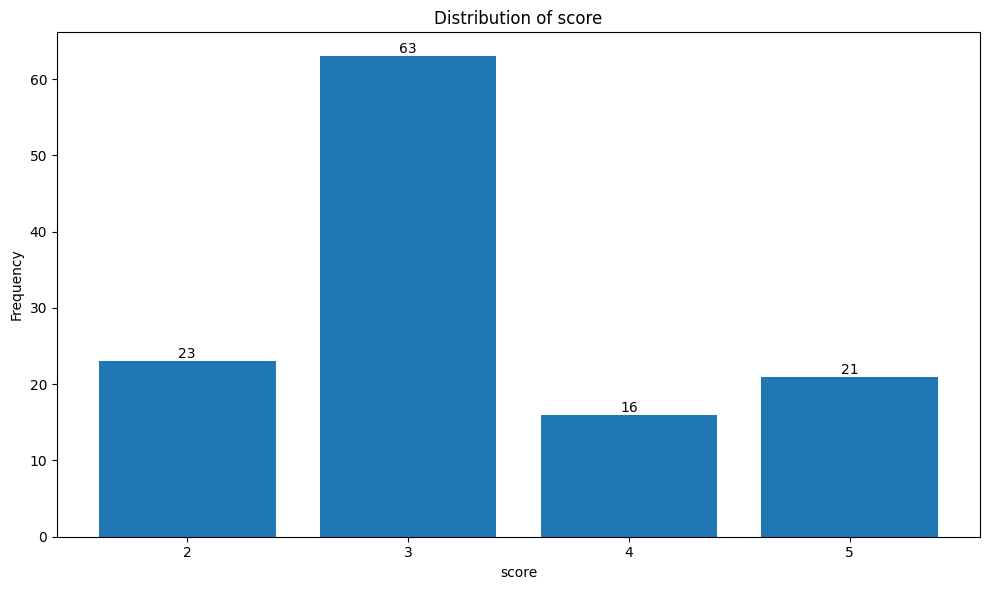

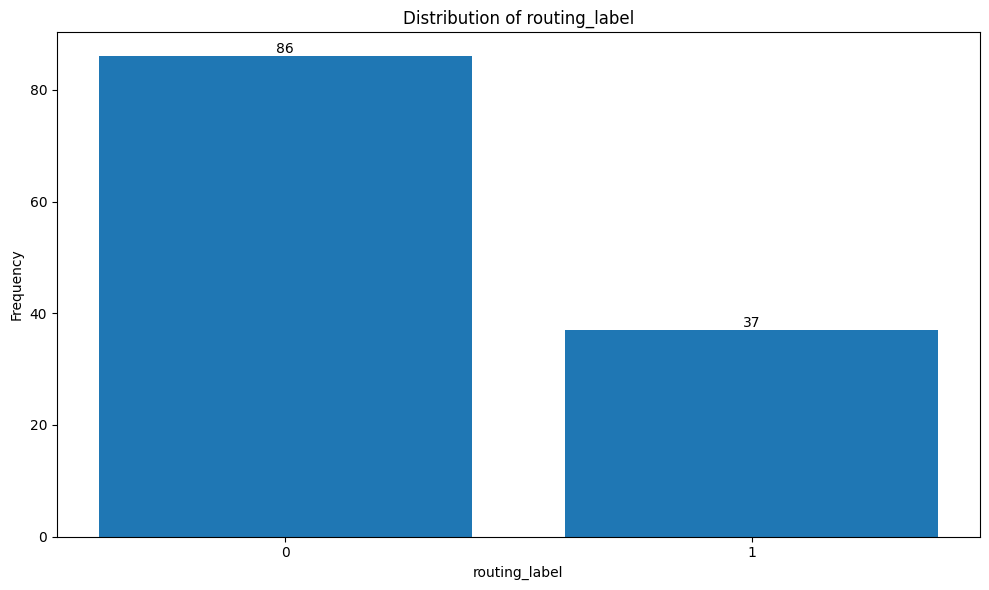

In [37]:
# 11. Visualize score and label distribution

visualize_distribution(df1_graded,key='score')

# Let us assume that if the score is >= 4, we will route to the small LLM model (indicating the response quality is good enough); 
# otherwise, we will route to the large LLM model. Under this assumption, the data distribution looks like this

df1_graded["routing_label"] = df1_graded["score"].apply(
    lambda x: 1 if (x >=4) else 0
)

visualize_distribution(df1_graded, key="routing_label")

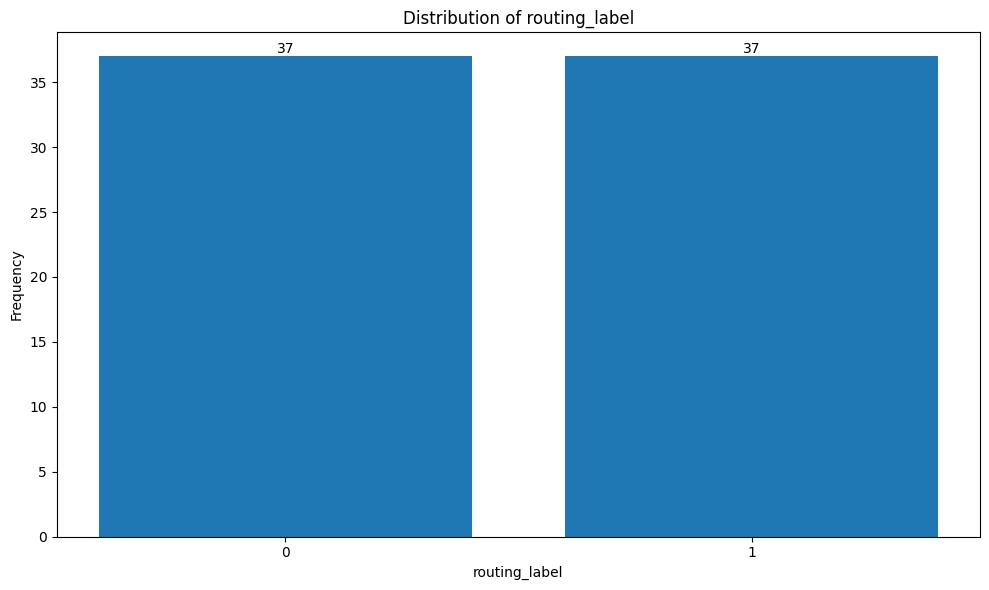

Train size: 74


In [43]:
# balance the dataset for our classification task
balanced_train_df = balance_dataset(df1_graded, key="routing_label")
visualize_distribution(balanced_train_df, key="routing_label")
print(f"Train size: {len(balanced_train_df)}")

In [44]:
# sample training data and reformat to format for finetuning
from sklearn.model_selection import train_test_split

n_total_samples = 37
train_ratio = 0.75  # 75% for training, 25% for validation

# Calculate the number of samples for each set
n_train = int(n_total_samples * train_ratio)
n_val = n_total_samples - n_train

# Sample the data
sampled_df = balanced_train_df.sample(n=n_total_samples, random_state=42)

# Split the sampled data into training and validation sets
train_df, val_df = train_test_split(sampled_df, train_size=n_train, random_state=42)

# Define output file names
output_file = "sampled_train_data.jsonl"
val_output_file = "sampled_val_data.jsonl"


# reformat to format for finetuning
training_data = []
for index, row in train_df.iterrows():
    prompt = str(build_prediction_prompt(user_question=row['Question'], sql_database_schema=row['Context']))
    completion = str(row['routing_label'])
    training_data.append({'prompt': prompt, 'completion': completion})
training_df = pd.DataFrame(training_data)

# Explicitly set the data types to string
training_df['prompt'] = training_df['prompt'].astype(str)
training_df['completion'] = training_df['completion'].astype('int64')

print(training_df.columns)
training_df.head(1)
training_df.to_json(output_file, orient="records", lines=True)



val_data = []
for index, row in val_df.iterrows():
    prompt = str(build_prediction_prompt(user_question=row['Question'], sql_database_schema=row['Context']))
    completion = str(row['routing_label'])
    val_data.append({'prompt': prompt, 'completion': completion})
validation_df = pd.DataFrame(val_data)

# Explicitly set the data types to string
validation_df['prompt'] = validation_df['prompt'].astype(str)
validation_df['completion'] = validation_df['completion'].astype('int64')

print(validation_df.columns)
validation_df.head(1)
validation_df.to_json(val_output_file, orient="records", lines=True)



Index(['prompt', 'completion'], dtype='object')
Index(['prompt', 'completion'], dtype='object')


### Train Classifier

In [15]:
# Finetune a small local LLM instruct model (DistilBERT) as binary classifier model
# %pip install transformers torch scikit-learn transformers[torch] accelerate -U
import torch
from torch.utils.data import Dataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support



# Load tokenizer and model
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)


class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.prompts = dataframe['prompt'].tolist()
        self.completions = dataframe['completion'].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __getitem__(self, idx):
        prompt = self.prompts[idx]
        completion = self.completions[idx]
        
        # Tokenize the prompt and completion
        encoding = self.tokenizer(
            prompt,
            completion,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        # Remove the batch dimension
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        
        # item['labels'] = torch.tensor(self.labels[idx])
        
        return item

    def __len__(self):
        return len(self.prompts)

# Create datasets with a DataFrame called training_df with 'prompt' and 'completion' columns
train_dataset = CustomDataset(training_df, tokenizer)
val_dataset = CustomDataset(validation_df, tokenizer)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
)

# Define metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()
print(eval_results)

# Save the model
model.save_pretrained("./finetuned_model")
tokenizer.save_pretrained("./finetuned_model")

# Inference example
def predict(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    outputs = model(**inputs)
    probs = outputs.logits.softmax(dim=-1)
    return probs.argmax().item()

# Test the model
test_text = "List all suppliers with their contact information."
prediction = predict(test_text)
print(f"Prediction for '{test_text}': {'Small_LLM' if prediction == 1 else 'Large_LLM'}")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ValueError: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

### FINE-TUNING JOB

In [45]:
BEDROCK_FINE_TUNING = False
if BEDROCK_FINE_TUNING == True:
    # upload to S3
    bucket_name = 'felixh-demo'
    prefix = 'finetuning'
    filename = output_file
    s3_uri = dataframe_to_s3_jsonl(training_df, bucket_name, prefix, filename)
    print(f's3_uri: {s3_uri}')

    # Set parameters
    customizationType = "FINE_TUNING"
    baseModelIdentifier = "arn:aws:bedrock:us-east-1::foundation-model/amazon.titan-text-express-v1"
    roleArn = "arn:aws:iam::026459568683:role/admin"
    jobName = "Text-to-SQL-Routing-Classifier-Job-V2"
    customModelName = "LLM-Routing-Classifier"
    hyperParameters = {
            "epochCount": "1", # The maximum number of iterations through the entire training dataset
            "batchSize": "1", # The number of samples processed before updating model parameters
            "learningRate": ".0005", # Multiplier that influences the learning rate at which model parameters are updated after each batch
            "learningRateWarmupSteps": "0"
        }
    trainingDataConfig = {"s3Uri": s3_uri}
    outputDataConfig = {"s3Uri": f"s3://{bucket_name}/{prefix}/output"}

    # Create job
    response_ft = bedrock_client.create_model_customization_job(
        jobName=jobName, 
        customModelName=customModelName,
        roleArn=roleArn,
        baseModelIdentifier=baseModelIdentifier,
        hyperParameters=hyperParameters,
        trainingDataConfig=trainingDataConfig,
        outputDataConfig=outputDataConfig
    )

    jobArn = response_ft.get('jobArn')
    print(f'jobArn: {jobArn}')

    response = bedrock_client.get_model_customization_job(jobIdentifier=jobArn)
    status = response.get('status')
    if status == 'Completed':
        outputModelArn = response.get("outputModelArn")
        print(f'outputModelArn: {outputModelArn}')
        customModelName = "LLM-Routing-Classifier"
        response_pt = bedrock_client.create_provisioned_model_throughput(
            modelId= outputModelArn,
            provisionedModelName= customModelName,
            modelUnits=1
        )

        provisionedModelArn = response_pt.get('provisionedModelArn')
        print(f'provisionedModelArn: {provisionedModelArn}')
    else:
        print(f'finetuning job status: {status}')
        print(f'finetuning job response: {response}')

In [46]:
if BEDROCK_FINE_TUNING == False: # use SageMaker
    from sagemaker import hyperparameters
    from sagemaker.jumpstart.estimator import JumpStartEstimator
    # reformat to format for finetuning SageMaker
    from sagemaker.s3 import S3Uploader
    import sagemaker
    import random
    import json
    template = {
        "prompt": "{prompt}\n\n",
        "completion": " {completion}",
    }
    with open("template.json", "w") as f:
        json.dump(template, f)

    bucket_name = 'felixh-demo'
    prefix = 'finetuning'
    filename = output_file

    train_data_location = f"s3://{bucket_name}/{prefix}"
    S3Uploader.upload(output_file, train_data_location)
    S3Uploader.upload("template.json", train_data_location)
    print(f"Training data: {train_data_location}")


    model_id = 'huggingface-llm-mistral-7b' #check https://sagemaker.readthedocs.io/en/stable/doc_utils/pretrainedmodels.html
    model_version = '*'
    
    finetuning_hyperparameters = hyperparameters.retrieve_default(
        model_id=model_id, model_version=model_version
    )
    print(finetuning_hyperparameters)

    finetuning_hyperparameters["epoch"] = "1"
    finetuning_hyperparameters["per_device_train_batch_size"] = "2"
    finetuning_hyperparameters["gradient_accumulation_steps"] = "2"
    finetuning_hyperparameters["instruction_tuned"] = "True"
    finetuning_hyperparameters["max_input_length"] = "32000"

    #validate parameters
    hyperparameters.validate(
        model_id=model_id, model_version=model_version, hyperparameters=finetuning_hyperparameters
    )
    
    # start training
    instruction_tuned_estimator = JumpStartEstimator(
        model_id=model_id,
        hyperparameters=finetuning_hyperparameters,
        instance_type="ml.g5.12xlarge",
    )
    instruction_tuned_estimator.fit({"train": train_data_location}, logs=True)

    # get metrics
    from sagemaker import TrainingJobAnalytics

    training_job_name = instruction_tuned_estimator.latest_training_job.job_name

    df = TrainingJobAnalytics(training_job_name=training_job_name).dataframe()
    df.head(10)

    # deploy fine-tuned model
    instruction_tuned_predictor = instruction_tuned_estimator.deploy()


Training data: s3://felixh-demo/finetuning


Using model 'huggingface-llm-mistral-7b' with wildcard version identifier '*'. You can pin to version '2.9.1' for more stable results. Note that models may have different input/output signatures after a major version upgrade.


{'peft_type': 'None', 'instruction_tuned': 'True', 'chat_dataset': 'False', 'epoch': '1', 'learning_rate': '6e-06', 'lora_r': '64', 'lora_alpha': '16', 'lora_dropout': '0', 'bits': '16', 'double_quant': 'True', 'quant_type': 'nf4', 'per_device_train_batch_size': '2', 'per_device_eval_batch_size': '8', 'add_input_output_demarcation_key': 'True', 'warmup_ratio': '0.1', 'train_from_scratch': 'False', 'fp16': 'False', 'bf16': 'True', 'evaluation_strategy': 'steps', 'eval_steps': '20', 'gradient_accumulation_steps': '8', 'logging_steps': '8', 'weight_decay': '0.2', 'load_best_model_at_end': 'True', 'max_train_samples': '-1', 'max_val_samples': '-1', 'seed': '10', 'max_input_length': '-1', 'validation_split_ratio': '0.2', 'train_data_split_seed': '0', 'preprocessing_num_workers': 'None', 'max_steps': '-1', 'gradient_checkpointing': 'True', 'early_stopping_patience': '3', 'early_stopping_threshold': '0.0', 'adam_beta1': '0.9', 'adam_beta2': '0.999', 'adam_epsilon': '1e-08', 'max_grad_norm': '

INFO:sagemaker:Creating training-job with name: hf-llm-mistral-7b-2024-08-23-00-58-36-841


2024-08-23 00:58:38 Starting - Starting the training job
2024-08-23 00:58:38 Pending - Training job waiting for capacity.........

### Evaluation

In [33]:
# Evaluate routing from accuracy,latency, and cost perspective

# Check if df exists in the current namespace
if 'df' not in globals():
    # If it doesn't exist, try to load it from a JSONL file
    file_path = 'question_query_good_results.jsonl'
    
    if os.path.exists(file_path):
        # Load the dataframe from the JSONL file
        df = pd.read_json(file_path, lines=True)
        print("df loaded from JSONL file.")
    else:
        print(f"Error: JSONL file not found at {file_path}")
else:
    print("df already exists in memory.")

if SQL_DATABASE == 'LOCAL':
    # Create a SQLite database connection
    conn = sqlite3.connect('routedb.db')


# for each row in ground truth data
results = []
df.columns = df.columns.str.capitalize()

LARGE_LLM_MODEL_ID = "anthropic.claude-3-sonnet-20240229-v1:0"
wrapper = BedrockLLMWrapper(debug=False, model_id=LARGE_LLM_MODEL_ID, max_token_count=512)
routeLLM = RouteLLMWrapper()
util = Util()
for row in df.itertuples():

    # invoke LLM pipeline with classifier
    classification_result, routeLLMresult = routeLLM.generate(user_question= row.Question, sql_database_schema= schema)
    small_generated_sql = extract_with_regex(routeLLMresult[0], SQL_PATTERN).replace("\\","") # converse API workaround
    small_query_time = classification_result[2] + routeLLMresult[2]
    small_cost = util.calculate_cost(classification_result[1], routeLLM.small_llm_model_id) + (util.calculate_cost(routeLLMresult[1], routeLLM.small_llm_model_id) if classification_result[0] == '1' else util.calculate_cost(routeLLMresult[1], routeLLM.large_llm_model_id))

    
    #invoke large LLM directly
    prompt = build_sqlquerygen_prompt(user_question= row.Question, sql_database_schema= schema)
    large_llm_result = wrapper.generate(prompt) # invoke large LLM
    #large_generated_sql, usage, query_time
    large_generated_sql = extract_with_regex(large_llm_result[0], SQL_PATTERN).replace("\\","")
    large_query_time = large_llm_result[2]
    large_cost = util.calculate_cost(large_llm_result[1], wrapper.model_id)
    
    # Calculate Text-to-SQL metrics
    ex_score = execution_accuracy(small_generated_sql, large_generated_sql)
    em_score = exact_set_match_accuracy(small_generated_sql, large_generated_sql, conn)
    ves_score = valid_efficiency_score(small_generated_sql, large_generated_sql, conn)

    result = {"small_generated_sql": small_generated_sql, 
              "small_cost": small_cost, 
              "small_query_time": small_query_time, 
              "large_generated_sql": large_generated_sql, 
              "large_cost": large_cost , 
              "large_query_time": large_query_time,
              "ex_score": ex_score,
              "em_score": em_score,
              "ves_score": ves_score}

    results.append(result)

conn.close()

evaluation_results = pd.DataFrame(results)

print(f'sum of small_cost: {evaluation_results[small_cost].sum()}')
print(f'sum of large_cost: {evaluation_results[large_cost].sum()}')

print(f'avg of small_query_time: {evaluation_results[small_query_time].avg()}')
print(f'avg of large_query_time: {evaluation_results[large_query_time].avg()}')

print(f'avg of ex_score: {evaluation_results[ex_score].avg()}')
print(f'avg of em_score: {evaluation_results[em_score].avg()}')
print(f'avg of ves_score: {evaluation_results[ves_score].avg()}')

df already exists in memory.
classification: 5
classification: 4
classification: 4
classification: 3
classification: 4
classification: 4
classification: 3
classification: 4
classification: 4
classification: 4
classification: 4
classification: 3
Error executing SQL: Execution failed on sql 'SELECT EXTRACT(YEAR FROM order_date) AS year, SUM(order_details.unit_price * order_details.quantity * (1 - order_details.discount)) AS total_sales
FROM orders
JOIN order_details ON orders.order_id = order_details.order_id
GROUP BY EXTRACT(YEAR FROM order_date)
ORDER BY year;': near "FROM": syntax error
Error executing SQL: Execution failed on sql 'SELECT EXTRACT(YEAR FROM order_date) AS year, SUM(order_details.unit_price * order_details.quantity * (1 - order_details.discount)) AS total_sales
FROM orders
JOIN order_details ON orders.order_id = order_details.order_id
GROUP BY EXTRACT(YEAR FROM order_date)
ORDER BY year;': near "FROM": syntax error
classification: 3
classification: 4
classification: 3
c

### Conclusion
In this tutorial, we have successfully built and evaluated a finetuned-LLM router. 
We generated synthetic labeled data using the LLM-as-a-judge method to train the model, finetuned an LLM classifier using Amazon Bedrock's API, 
and conducted offline evaluation.

### Sources

https://github.com/lm-sys/RouteLLM

https://medium.com/@learngrowthrive.fast/routellm-achieves-90-gpt-4-quality-at-80-lower-cost-6686e5f46e2a

https://medium.com/ai-insights-cobet/beyond-basic-chatbots-how-semantic-router-is-changing-the-game-783dd959a32d

https://medium.com/@bhawana.prs/semantic-routes-in-llms-to-make-chatbots-more-accurate-d99c17e30487


popular benchmarks: MT Bench, MMLU, and GSM8K.

* Semantic routing: Using a vector analysis to route the query to the closest “cluster”
https://github.com/aurelio-labs/semantic-router

* Prompt Chaining: Similar to what has been implemented inside Bedrock agents, and LangChain’s Custom function, these use an small LLM to analyze the question and route it to the next part of the chain. https://aws.amazon.com/blogs/machine-learning/enhance-conversational-ai-with-advanced-routing-techniques-with-amazon-bedrock/
You can optimize this by having the “router” model answer directly simple questions instead of routing them to another model.

* Intent Classification: Creating a custom model, similar to ROHF or Rerankers to classify the query and route it to the right LLM.  
https://medium.com/aimonks/intent-classification-generative-ai-based-application-architecture-3-79d2927537b4

https://www.anyscale.com/blog/building-an-llm-router-for-high-quality-and-cost-effective-responses

https://github.com/aws-samples/amazon-bedrock-samples/blob/main/function-calling/function_calling_text2SQL_converse_bedrock_streamlit.py

https://github.com/aws-samples/amazon-bedrock-samples/tree/main/rag-solutions/sql-query-generator

### Next steps

Explore other data sources:  https://bird-bench.github.io/ , latest spyder dataset, any SQL dataset from HF

<!-- # https://huggingface.co/datasets/b-mc2/sql-create-context

# from datasets import load_dataset
# # %sql sqlite:///routedb.db
# # to load SQL dataset from starcoder
## ds = load_dataset("bigcode/starcoderdata", data_dir="sql", split="train", token=True)
# ds = load_dataset("b-mc2/sql-create-context", split="train", token=True)
# from datasets import load_dataset_builder
# ds_builder = load_dataset_builder("b-mc2/sql-create-context")
# ds_builder.info.description
# ds_builder.info.features -->


### SCRATCHPAD

In [45]:
# mistral.mixtral-8x7b-instruct-v0:1

# Use the native inference API to send a text message to Anthropic Claude.

import boto3
import json

from botocore.exceptions import ClientError

# Create a Bedrock Runtime client in the AWS Region of your choice.
bedrock_runtime_client = boto3.client("bedrock-runtime", region_name="us-east-1")

# Set the model ID, e.g., Claude 3 Haiku.
model_id = "mistral.mixtral-8x7b-instruct-v0:1"

# Define the prompt for the model.
prompt = "Describe the purpose of a 'hello world' program in one line."

# Setup the system prompts and messages to send to the model.
system_prompts = [] # [{"text": "You are a helpful AI Assistant."}]
message = {
    "role": "user",
    "content": [{"text": prompt}]
}

messages = []
messages.append(message)

try:
    # Base inference parameters to use.
    inference_config = {"temperature": 0.0}
    # Additional inference parameters to use.
    additional_model_fields = {"top_k": 5}

    # Send the message.
    response = bedrock_runtime_client.converse(
        modelId=model_id,
        messages=messages,
        system=system_prompts,
        inferenceConfig=inference_config,
        additionalModelRequestFields=additional_model_fields
    )

    # Log token usage.
    text = response['output'].get('message').get('content')[0].get('text')
    print(f'text: {text}')
    token_usage = response['usage']
    print(f'token_usage: {token_usage}')
    latency = response['metrics'].get('latencyMs')
    print(f'latency: {latency}')
    
except Exception as e:
    print("Error with calling Bedrock: "+str(e))
    attempt+=1
    if attempt>3:
        print("Max attempts reached!")
        result_text = str(e)
        
    else:#retry in 10 seconds
        print("retry")
        time.sleep(10)

text:  A "Hello World" program is a simple program that outputs the text "Hello, World!" and its purpose is to introduce and familiarize beginners with the basic syntax and structure of a programming language.
token_usage: {'inputTokens': 22, 'outputTokens': 42, 'totalTokens': 64}
latency: 1328
